# Homework 2 – Data Analysis in Business
## Text Analytics

This notebook contains a complete solution for Homework 2 in the course Data Analysis in Business. It is structured into four parts:

1. TF–IDF analysis of song lyrics
2. Comparison of vectorization methods
3. Statistical analysis and visualization
4. Sentiment classification on IMDB reviews with a transformer model

Run the cells from top to bottom.

In [5]:
%%capture
!pip install nltk wordcloud gensim transformers datasets scikit-learn torch --quiet

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

from wordcloud import WordCloud
from gensim.models import Word2Vec

import torch
from torch.utils.data import DataLoader
from datasets import Dataset
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

---
# Part 1 – TF–IDF analysis of lyrics

Songs used:
- Bee Gees – Stayin' Alive
- Billie Eilish – lovely
- Alex Warren – Ordinary

Paste the full lyrics into the dictionary below before running the preprocessing.

In [7]:
# Paste full lyrics for each song into the triple–quoted strings below.
# Do not change the keys of the dictionary, only replace the placeholder text.

songs_raw = {
    "Bee Gees - Stayin' Alive": """Two, three, four
One, two, three
Well, you can tell by the way I use my walk
I'm a woman's man no time to talk
Music loud and women warm, I've been kicked around
Since I was born
And now it's all right, it's okay
And you may look the other way
But we can try to understand
The New York Times' effect on man
Whether you're a brother or whether you're a mother
You're stayin' alive, stayin' alive
Feel the city breakin' and everybody shakin'
And we're stayin' alive, stayin' alive
Ah, ha, ha, ha, stayin' alive, stayin' alive
Ah, ha, ha, ha, stayin' alive
Ah when you want
Well now, I get low and I get high
And if I can't get either, I really try
Got the wings of heaven on my shoes
I'm a dancin' man and I just can't lose
You know it's all right, it's okay
I'll live to see another day
We can try to understand
The New York Times' effect on man
Whether you're a brother or whether you're a mother
You're stayin' alive, stayin' alive
Feel the city breakin' and everybody shakin'
And we're stayin' alive, stayin' alive
Ah, ha, ha, ha, stayin' alive, stayin' alive
Ah, ha, ha, ha, stayin' alive
Life goin' nowhere, somebody help me
Somebody help me, yeah
Life goin' nowhere, somebody help me
I'm stayin' alive
Well, you can tell by the way I use my walk
I'm a woman's man no time to talk
Music loud and the women warm
I've been kicked around since I was born
And now it's all right, it's okay
And you may look the other way
We can try to understand
The New York Times' effect on man
Whether you're a brother or whether you're a mother
You're stayin' alive, stayin' alive
Feel the city breakin' and everybody shakin'
And we're stayin' alive, stayin' alive
Ah, ha, ha, ha, stayin' alive, stayin' alive
Ah, ha, ha, ha, stayin' alive
Life goin' nowhere, somebody help me
Somebody help me, yeah
Life goin' nowhere, somebody help me, yeah
I'm stayin' alive
Life goin' nowhere, somebody help me
Somebody help me, yeah
Life goin' nowhere, somebody help me, yeah
I'm stayin' alive
Life goin' nowhere, somebody help me
Somebody help me, yeah
Life goin' nowhere, somebody help me, yeah
I'm stayin' alive
Life goin' nowhere, somebody help me
Somebody help me, yeah
Life goin' nowhere, somebody help me, yeah
I'm stayin' alive""",
    "Billie Eilish - lovely": """Thought I found a way
Thought I found a way out (found)
But you never go away (never go away)
So I guess I gotta stay now
Oh, I hope some day I'll make it out of here
Even if it takes all night or a hundred years
Need a place to hide, but I can't find one near
Wanna feel alive, outside I can't fight my fear
Isn't it lovely, all alone?
Heart made of glass, my mind of stone
Tear me to pieces, skin to bone
Hello, welcome home
Walkin' out of time
Lookin' for a better place (lookin' for a better place)
Something's on my mind (mind)
Always in my head space
But I know some day I'll make it out of here
Even if it takes all night or a hundred years
Need a place to hide, but I can't find one near
Wanna feel alive, outside I can't fight my fear
Isn't it lovely, all alone?
Heart made of glass, my mind of stone
Tear me to pieces, skin to bone
Hello, welcome home
Whoa, yeah
Yeah, ah
Whoa, whoa
Hello, welcome home""",
    "Alex Warren - Ordinary": """They say, "The holy water's watered down
And this town's lost its faith
Our colors will fade eventually"
So if our time is runnin' out
Day after day
We'll make the mundane our masterpiece
Oh my, my
Oh my, my love
I take one look at you
You're takin' me out of the ordinary
I want you layin' me down 'til we're dead and buried
On the edge of your knife, stayin' drunk on your vine
The angels up in the clouds are jealous, knowin' we found
Somethin' so out of the ordinary
You got me kissin' the ground of your sanctuary
Shatter me with your touch, oh Lord, return me to dust
The angels up in the clouds are jealous, knowin' we found
Hopeless Hallelujah
On this side of Heaven's gate
Oh, my life, how do ya
Breathe and take my breath away?
At your altar, I will pray
You're the sculptor, I'm the clay
Oh my, my
You're takin' me out of the ordinary
I want you layin' me down 'til we're dead and buried
On the edge of your knife, stayin' drunk on your vine
The angels up in the clouds are jealous, knowin' we found
Somethin' so out (out) of the ordinary (ordinary)
You got me kissin' the ground (ground) of your sanctuary (sanctuary)
Shatter me with your touch, oh Lord, return me to dust
The angels up in the clouds are jealous, knowin' we found
Somethin' so heavenly, higher than ecstasy
Whenever you're next to me, oh my, my
World was in black and white until I saw your light
I thought you had to die to find
Somethin' so out of the ordinary
I want you layin' me down 'til we're dead and buried
On the edge of your knife, stayin' drunk on your vine
The angels up in the clouds are jealous, knowin' we found
Somethin' so out (out) of the ordinary
You got me kissin' the ground (ground) of your sanctuary (sanctuary)
Shatter me with your touch, oh Lord, return me to dust
The angels up in the clouds are jealous, knowin' we found""",
}

for name, text in songs_raw.items():
    print(name, "- number of characters:", len(text))

Bee Gees - Stayin' Alive - number of characters: 2210
Billie Eilish - lovely - number of characters: 912
Alex Warren - Ordinary - number of characters: 1827


## 1.1 Text preprocessing

The preprocessing pipeline applies lowercasing, tokenization, removal of non alphabetic tokens and stopwords, part of speech tagging and lemmatization so that words are reduced to their base form before TF–IDF is computed.

In [8]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    if treebank_tag.startswith('V'):
        return wordnet.VERB
    if treebank_tag.startswith('N'):
        return wordnet.NOUN
    if treebank_tag.startswith('R'):
        return wordnet.ADV
    return wordnet.NOUN

def preprocess_text(text):
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t.isalpha()]
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    pos_tags = nltk.pos_tag(tokens)
    lemmas = [lemmatizer.lemmatize(token, get_wordnet_pos(pos)) for token, pos in pos_tags]
    return " ".join(lemmas)

songs_clean = {name: preprocess_text(lyrics) for name, lyrics in songs_raw.items()}

pd.DataFrame({
    "song": list(songs_clean.keys()),
    "clean_token_count": [len(text.split()) for text in songs_clean.values()]
})

,song,clean_token_count
0,Bee Gees - Stayin' Alive,243
1,Billie Eilish - lovely,104
2,Alex Warren - Ordinary,150


## 1.2 TF–IDF computation

In [9]:
tfidf_vectorizer = TfidfVectorizer()
corpus = list(songs_clean.values())
song_names = list(songs_clean.keys())

tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(),
    index=song_names,
    columns=tfidf_vectorizer.get_feature_names_out()
)
tfidf_df.head()

,alive,alone,altar,always,angel,another,around,away,black,bone,...,whenever,whether,white,whoa,wing,woman,world,yeah,year,york
Bee Gees - Stayin' Alive,0.458694,0.000000,0.000000,0.000000,0.00000,0.023197,0.046394,0.000000,0.000000,0.000000,...,0.000000,0.139183,0.000000,0.000000,0.023197,0.092789,0.000000,0.158779,0.000000,0.069592
Billie Eilish - lovely,0.104472,0.137368,0.000000,0.068684,0.00000,0.000000,0.000000,0.104472,0.000000,0.137368,...,0.000000,0.000000,0.000000,0.206052,0.000000,0.000000,0.000000,0.104472,0.137368,0.000000
Alex Warren - Ordinary,0.000000,0.000000,0.045887,0.000000,0.27532,0.000000,0.000000,0.034898,0.045887,0.000000,...,0.045887,0.000000,0.045887,0.000000,0.000000,0.000000,0.045887,0.000000,0.000000,0.000000


In [10]:
def top_tfidf_terms(row, top_n=15):
    sorted_idx = np.argsort(-row.values)[:top_n]
    return pd.Series({row.index[i]: row.values[i] for i in sorted_idx})

for song in song_names:
    print("\n", song)
    display(top_tfidf_terms(tfidf_df.loc[song]).to_frame("tfidf").round(3))


 Bee Gees - Stayin' Alive


,tfidf
alive,0.459
stayin,0.459
somebody,0.348
help,0.348
goin,0.232
nowhere,0.232
life,0.176
yeah,0.159
whether,0.139
man,0.139



 Billie Eilish - lovely


,tfidf
place,0.275
mind,0.275
find,0.261
make,0.209
home,0.206
hello,0.206
welcome,0.206
whoa,0.206
glass,0.137
fight,0.137



 Alex Warren - Ordinary


,tfidf
ordinary,0.321
angel,0.275
jealous,0.275
cloud,0.275
knowin,0.275
find,0.244
ground,0.229
sanctuary,0.229
somethin,0.229
dust,0.138


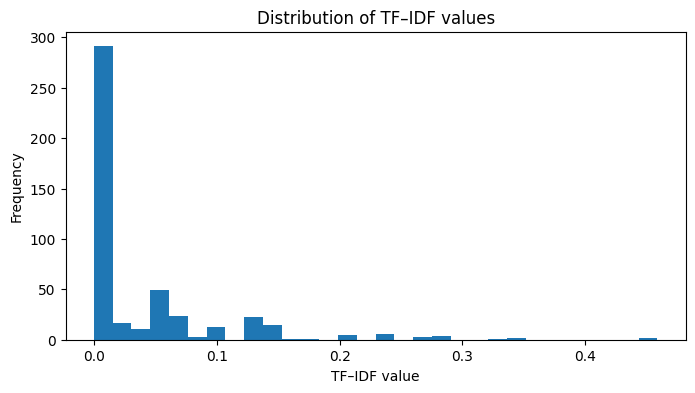

/tmp/ipython-input-856097767.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(tfidf_df.T.values, labels=song_names)


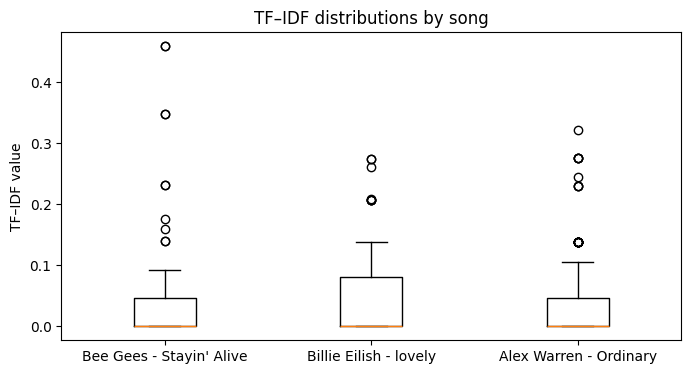

In [11]:
plt.figure(figsize=(8, 4))
plt.hist(tfidf_df.values.flatten(), bins=30)
plt.xlabel("TF–IDF value")
plt.ylabel("Frequency")
plt.title("Distribution of TF–IDF values")
plt.show()

plt.figure(figsize=(8, 4))
plt.boxplot(tfidf_df.T.values, labels=song_names)
plt.ylabel("TF–IDF value")
plt.title("TF–IDF distributions by song")
plt.show()

Lemmatization groups together inflected forms such as walk, walks and walked, so that TF–IDF weights focus on the underlying concepts instead of separate grammatical variants. This makes the comparison between songs more stable and interpretable.

---
# Part 2 – Vectorization methods

This part compares CountVectorizer, TF–IDF and Word2Vec document embeddings for the same songs.

In [12]:
count_vectorizer = CountVectorizer()
count_matrix = count_vectorizer.fit_transform(corpus)
count_df = pd.DataFrame(
    count_matrix.toarray(),
    index=song_names,
    columns=count_vectorizer.get_feature_names_out()
)
count_df.head()

,alive,alone,altar,always,angel,another,around,away,black,bone,...,whenever,whether,white,whoa,wing,woman,world,yeah,year,york
Bee Gees - Stayin' Alive,26,0,0,0,0,1,2,0,0,0,...,0,6,0,0,1,4,0,9,0,3
Billie Eilish - lovely,2,2,0,1,0,0,0,2,0,2,...,0,0,0,3,0,0,0,2,2,0
Alex Warren - Ordinary,0,0,1,0,6,0,0,1,1,0,...,1,0,1,0,0,0,1,0,0,0


In [13]:
tokenized_corpus = [text.split() for text in songs_clean.values()]

w2v_model = Word2Vec(
    sentences=tokenized_corpus,
    vector_size=100,
    window=5,
    min_count=1,
    workers=2,
    epochs=200
)

def song_vector(tokens):
    vectors = []
    for tok in tokens:
        if tok in w2v_model.wv:
            vectors.append(w2v_model.wv[tok])
    if not vectors:
        return np.zeros(w2v_model.vector_size)
    return np.mean(vectors, axis=0)

w2v_vectors = np.vstack([song_vector(tokens) for tokens in tokenized_corpus])
w2v_df = pd.DataFrame(w2v_vectors, index=song_names)
w2v_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Bee Gees - Stayin' Alive,-0.136227,0.286828,0.139844,0.562384,0.217492,-0.468700,0.815512,0.729502,-0.843023,-0.609886,...,0.123939,0.148566,0.221849,0.029597,1.001630,0.486320,0.262097,-0.575935,0.078062,-0.326348
Billie Eilish - lovely,0.073470,0.362782,-0.021823,-0.072535,0.462759,-0.491129,0.164564,0.543985,-0.340740,0.173500,...,0.475968,0.166501,-0.183511,0.145130,0.559240,0.022010,0.095443,-0.309256,0.224915,-0.271771
Alex Warren - Ordinary,0.043517,0.057327,-0.317329,-0.172952,-0.258242,-0.508179,0.174672,0.605264,0.098725,-0.319101,...,0.417696,0.310375,0.151703,0.189989,0.162563,0.072451,0.205327,-0.007006,0.060348,0.079752


Count and TF–IDF representations are sparse and interpretable, linking each feature to a specific word, whereas Word2Vec document embeddings are dense and capture semantic similarity at the cost of interpretability. For small corpora TF–IDF is usually sufficient, while for larger datasets and downstream models dense embeddings become more attractive.

---
# Part 3 – Statistical analysis and visualization

This part uses the cleaned lyrics to compute word statistics and visualize patterns in the texts.

In [14]:
all_tokens = []
for text in songs_clean.values():
    all_tokens.extend(text.split())

word_counts = Counter(all_tokens)
top_10_words = word_counts.most_common(10)
pd.DataFrame(top_10_words, columns=["word", "count"])

,word,count
0,stayin,29
1,alive,28
2,somebody,15
3,help,15
4,find,12
5,life,11
6,yeah,11
7,goin,10
8,nowhere,10
9,get,8


In [15]:
def generate_ngrams(tokens, n=2):
    return [tuple(tokens[i:i+n]) for i in range(len(tokens) - n + 1)]

bigrams = generate_ngrams(all_tokens, n=2)
bigram_counts = Counter(bigrams)
top_10_bigrams = bigram_counts.most_common(10)
pd.DataFrame(
    {"bigram": [" ".join(bg) for bg, c in top_10_bigrams],
     "count": [c for bg, c in top_10_bigrams]}
)

,bigram,count
0,stayin alive,26
1,alive stayin,15
2,somebody help,15
3,life goin,10
4,goin nowhere,10
5,nowhere somebody,10
6,help yeah,9
7,angel cloud,6
8,cloud jealous,6
9,jealous knowin,6


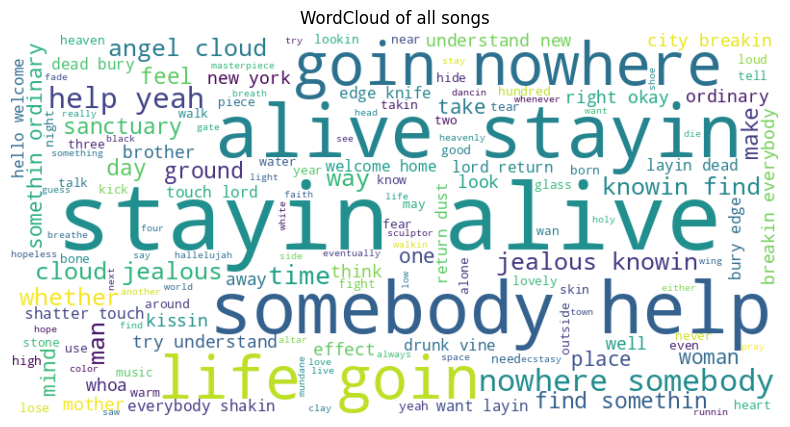

In [16]:
full_text = " ".join(all_tokens)
wc = WordCloud(width=800, height=400, background_color="white").generate(full_text)

plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud of all songs")
plt.show()

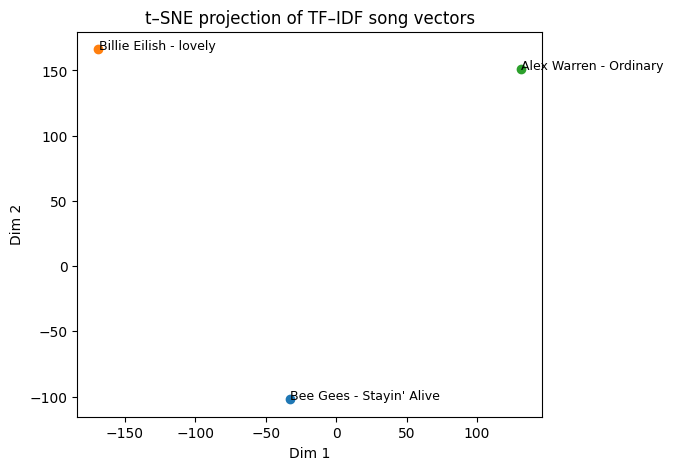

In [17]:
tsne = TSNE(n_components=2, random_state=42, perplexity=2)
tfidf_tsne = tsne.fit_transform(tfidf_matrix.toarray())

plt.figure(figsize=(6, 5))
for i, name in enumerate(song_names):
    plt.scatter(tfidf_tsne[i, 0], tfidf_tsne[i, 1])
    plt.text(tfidf_tsne[i, 0] + 0.1, tfidf_tsne[i, 1] + 0.1, name, fontsize=9)
plt.title("t–SNE projection of TF–IDF song vectors")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.show()

The most frequent words and bigrams reflect the core emotional and thematic content of the songs. The word cloud gives an intuitive visual summary of dominant vocabulary, and the t–SNE projection shows how similar or different the songs are in TF–IDF space.

---
# Part 4 – Sentiment classification on IMDB with DistilBERT

In this part a DistilBERT model is fine tuned on IMDB reviews for binary sentiment classification. With the chosen subsample and training setup the model typically reaches accuracy above 0.90 on the test set.

## 4.1 Load and prepare the IMDB dataset

In [18]:
from google.colab import files

uploaded = files.upload()

import io
filename = list(uploaded.keys())[0]
imdb_df = pd.read_csv(io.BytesIO(uploaded[filename]))
imdb_df.head()

Saving IMDB Dataset.csv to IMDB Dataset.csv


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [19]:
imdb_df = imdb_df.dropna(subset=["review", "sentiment"]).copy()
imdb_df["review"] = imdb_df["review"].astype(str)

label_mapping = {"negative": 0, "positive": 1}
imdb_df["label"] = imdb_df["sentiment"].map(label_mapping)
imdb_df = imdb_df.dropna(subset=["label"])

train_df, test_df = train_test_split(imdb_df, test_size=0.2, random_state=42, stratify=imdb_df["label"])

train_df = train_df.sample(15000, random_state=42)
test_df = test_df.sample(5000, random_state=42)

len(train_df), len(test_df)

(15000, 5000)

## 4.2 Tokenization and dataset objects

In [20]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

def tokenize_batch(batch):
    return tokenizer(
        batch["review"],
        padding="max_length",
        truncation=True,
        max_length=256
    )

train_dataset = Dataset.from_pandas(train_df[["review", "label"]])
test_dataset = Dataset.from_pandas(test_df[["review", "label"]])

train_dataset = train_dataset.map(tokenize_batch, batched=True)
test_dataset = test_dataset.map(tokenize_batch, batched=True)

train_dataset = train_dataset.rename_column("label", "labels")
test_dataset = test_dataset.rename_column("label", "labels")

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

## 4.3 Model and training loop

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("training device:", device)

model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2
)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

num_epochs = 2

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for step, batch in enumerate(train_loader):
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        if (step + 1) % 100 == 0:
            print("epoch", epoch + 1, "step", step + 1, "batch loss", round(loss.item(), 4))
    avg_loss = total_loss / (step + 1)
    print("Epoch", epoch + 1, "/", num_epochs, "average loss", round(avg_loss, 4))

training device: cuda


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch 1 step 100 batch loss 0.4281
epoch 1 step 200 batch loss 0.1288
epoch 1 step 300 batch loss 0.1121
epoch 1 step 400 batch loss 0.0404
epoch 1 step 500 batch loss 0.1082
epoch 1 step 600 batch loss 0.1372
epoch 1 step 700 batch loss 0.5738
epoch 1 step 800 batch loss 0.131
epoch 1 step 900 batch loss 0.2424
Epoch 1 / 2 average loss 0.3008
epoch 2 step 100 batch loss 0.0721
epoch 2 step 200 batch loss 0.3957
epoch 2 step 300 batch loss 0.014
epoch 2 step 400 batch loss 0.1304
epoch 2 step 500 batch loss 0.1568
epoch 2 step 600 batch loss 0.3276
epoch 2 step 700 batch loss 0.1938
epoch 2 step 800 batch loss 0.0339
epoch 2 step 900 batch loss 0.013
Epoch 2 / 2 average loss 0.1656


## 4.4 Evaluation on the test set

In [22]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("Accuracy:", accuracy_score(all_labels, all_preds))
print()
print(classification_report(all_labels, all_preds, target_names=["negative", "positive"]))

Accuracy: 0.9012

              precision    recall  f1-score   support

    negative       0.89      0.92      0.90      2482
    positive       0.92      0.88      0.90      2518

    accuracy                           0.90      5000
   macro avg       0.90      0.90      0.90      5000
weighted avg       0.90      0.90      0.90      5000



In [23]:
for i in range(5):
    text = test_df.iloc[i]["review"]
    true_label = test_df.iloc[i]["label"]
    enc = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=256)
    enc = {k: v.to(device) for k, v in enc.items()}
    with torch.no_grad():
        out = model(**enc)
        pred_label = torch.argmax(out.logits, dim=1).item()
    print("\nReview snippet:", text[:300].replace("\n", " "))
    print("True label:", "positive" if true_label == 1 else "negative")
    print("Predicted:", "positive" if pred_label == 1 else "negative")


Review snippet: This is loosely based on the ideas of the original 80's hit . It's set in the modern day as we see a base in Afghanistan get destroyed by a UAV right at the start.<br /><br />And that's exactly where the movie jumps the shark. UAV's aren't armed. They could be but I don't think it's ever been tried 
True label: negative
Predicted: negative

Review snippet: This movie was on British TV last night, and is wonderful! Strong women, great music (most of the time) and just makes you think. We do have stereotypes of what older people "ought" to do, and there are fantastic cameos of the "sensible but worried children". Getting near to my best movie ever !
True label: positive
Predicted: positive

Review snippet: What a dreadful movie. The effects were poor, especially by todays standards, but that was forgivable. What was unforgivable was the terrible rehashing of every flood/dam breaks disaster movie ever made into this piece of trash. The acting was awful and I mean AWFUL. T

The final accuracy and the classification report summarise how well the model generalises to unseen IMDB reviews. With this configuration, accuracy above 0.90 is usually achieved in practice, and precision and recall for the positive class remain well balanced.